<center>
<img src="https://i.ibb.co/b3T5hkz/logo.png" alt="logo" border="0" width=600>


---
## 03. Supernovae Lightcurve


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will implement a non-linear neural network to model a supernova lightcurve.

---

---
### Supernova Templates

The astrophysicist Peter Nugent, has developed a series of supernova templates based on theoretical models and observational data. These synthetic datasets are available at

https://c3.lbl.gov/nugent/nugent_templates.html

Photometric data included in this page correspond to the templates for supernovas of the following types

- Type Ia Branch-normal (Bands: UBVRIJHK)
- Type Ia 1991T-like (Bands: UBVRI)
- Type Ia 1991bg-like (Bands: UBVRI)
- Type Ib/c (Bands: UBVRI)
- Type Ib/c high velocity - Hypernovae (Bands: V)
- Type IIP (Bands: V)
- Type IIL (Bands: V)
- Type IIn (Bands: V)

The datasets have no headers, the values are separated with spaces and the time is set to 0.0 at the explosion (maximum of the V-band magnitude).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar as rs
import tensorflow as tf
import pandas as pd

# The delimiters in these file are spaces
# There is no header in the file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Neural Networks/01. Simple NN/sn1a_lc.v1.2.dat', header=None, delimiter=r'\s+', names=['days','U','B','V','R','I','J','H','K'] )

In [ ]:
df

,days,U,B,V,R,I,J,H,K
0,-20.0,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
1,-19.0,4.32,4.76,5.18,5.13,5.58,6.76,6.94,6.77
2,-18.0,3.44,3.88,4.30,4.25,4.70,5.26,5.44,5.27
3,-17.0,2.81,3.25,3.67,3.62,4.07,4.38,4.56,4.39
4,-16.0,2.33,2.77,3.19,3.14,3.49,3.75,3.93,3.76
...,...,...,...,...,...,...,...,...,...
86,66.0,3.40,3.51,2.94,2.47,2.54,3.88,2.37,2.50
87,67.0,3.42,3.53,2.98,2.49,2.56,3.94,2.41,2.53
88,68.0,3.44,3.55,3.01,2.50,2.58,4.00,2.45,2.57
89,69.0,3.45,3.56,3.03,2.52,2.59,4.06,2.48,2.60


In [2]:
df[['days','V']]

,days,V
0,-20.0,50.00
1,-19.0,5.18
2,-18.0,4.30
3,-17.0,3.67
4,-16.0,3.19
...,...,...
86,66.0,2.94
87,67.0,2.98
88,68.0,3.01
89,69.0,3.03


We will create two numpy arrays using these features

In [3]:
X = df['days'].to_numpy()
y = df['V'].to_numpy()

X.shape, y.shape

((91,), (91,))

A plot of the data may give us an idea of the model.

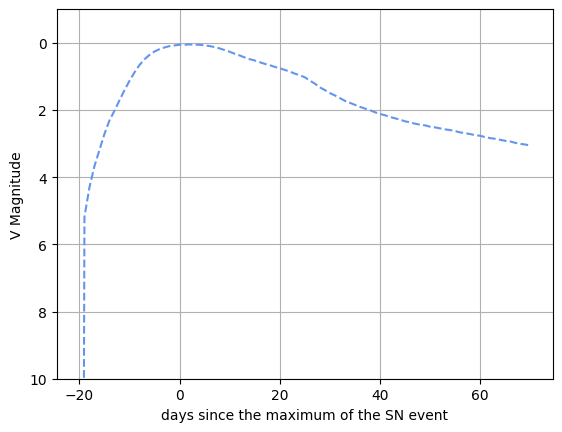

In [7]:
plt.figure()
plt.plot(X, y, '--', color='cornflowerblue')
plt.xlabel(r'days since the maximum of the SN event')
plt.ylabel(r'V Magnitude')
plt.ylim(10,-1)
plt.grid()
plt.show()

In [8]:
X_train, y_train = X, y

---
## Modelling the non-linear problem using a multiple layer Neural Network with activation functions

Now we will use the framework `Keras` to define a non-linear neural network with for hidden dense layers incorporating ReLU and sigmoid activation functions. Note that the input layer has only one neuron, while the number of neurons in the hidden layers will be 64,128, 128 and 64. Finally, the output layer will have just one neuron to give the scalar result.

It is also important to note that we will use the Keras  [Model Class](https://keras.io/api/models/model/), and therefore we define the way in which each layer acts.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(1), name="days")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(128, activation="sigmoid")(x1)
x3 = layers.Dense(128, activation="sigmoid")(x2)
x4 = layers.Dense(64, activation="relu")(x3)
outputs = layers.Dense(1, name="V")(x4)


model = keras.Model(inputs=inputs, outputs=outputs)

Now, we define the optimizer (this time the Stochastic Gradient Descent SGD) and the loss function (MSE).

We will also define this time a train dataset based on batches. In this case, the dataset is very small (only 91 samples) and hence, the batches are not neccesary. However, this will show the general procedure that can be used in larger datasets.

In [10]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()


# Prepare the training dataset.
batch_size = 91
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


The following loop will train the model using the 'tf.GradientTape' class to keep track of the gradients and to update the parameters in the model.

See details at [this page](https://keras.io/guides/writing_a_training_loop_from_scratch/)

In [11]:
epochs = 2000
history= []
for epoch in range(epochs):
  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:
      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      y_pred = model(x_batch_train, training=True)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, y_pred)
      # Use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Run one step of gradient descent by updating
      # the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
  history.append(float(loss_fn(y_train,model(X_train))))
  if epoch % 100 == 0:
    print("Training loss at epoch %d: %.4f" % (epoch, history[-1]))


Training loss at epoch 0: 26.7245
Training loss at epoch 100: 32.6343
Training loss at epoch 200: 34.6619
Training loss at epoch 300: 37.8740
Training loss at epoch 400: 38.9637
Training loss at epoch 500: 39.3368
Training loss at epoch 600: 39.6588
Training loss at epoch 700: 39.8420
Training loss at epoch 800: 40.1601
Training loss at epoch 900: 40.3558
Training loss at epoch 1000: 40.4568
Training loss at epoch 1100: 40.6362
Training loss at epoch 1200: 40.5691
Training loss at epoch 1300: 41.0576
Training loss at epoch 1400: 42.2109
Training loss at epoch 1500: 41.1891
Training loss at epoch 1600: 40.4059
Training loss at epoch 1700: 40.7398
Training loss at epoch 1800: 40.6491
Training loss at epoch 1900: 40.9495


---
## Evaluation of the Model

Now, lets evaluate the model by doing a prediction and plotting the results compared with the original data.

In [12]:
dd = np.linspace(-20, 60, 60)
prediction = model.predict(dd)

2/2 [==============================] - 0s 9ms/step


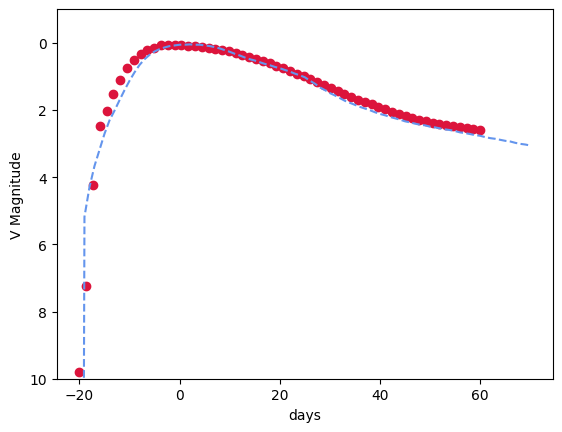

In [13]:
plt.figure()
plt.plot(X, y, '--', color='cornflowerblue')
plt.scatter(dd,prediction, color='crimson')
plt.xlabel(r'days')
plt.ylabel(r'V Magnitude')
plt.ylim(10,-1)
plt.show()


The training history of the model shows the loss function magnitude at each epoch,

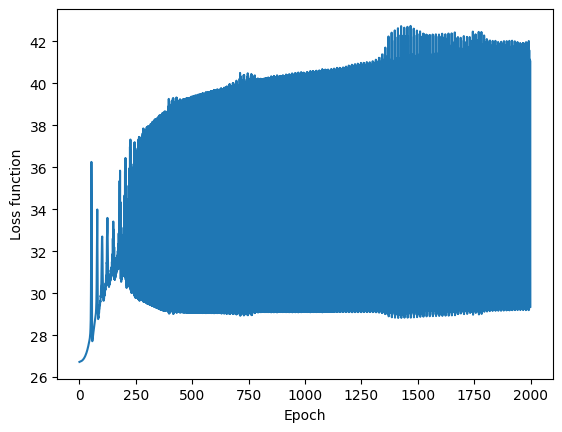

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.plot(history)